# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Данных достаточно для обучения модели, но, весьма вероятно, мало для получения стабильной хорошей метрики и успешного применения. При обучении попробуем увеличить объем данных аугментацией.

<AxesSubplot:>

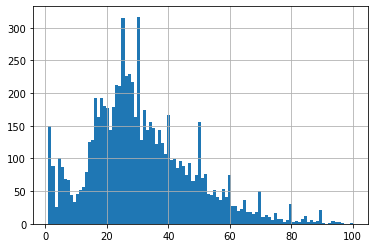

In [4]:
labels.real_age.hist(bins=100)

На гистромме видны пики на юбилейных датах - 1, 25, 30, 40, 50, 60, 70, 80 и 90. Вероятно, точный не всегда был известен, либо округлялся на каком-то этапе сборе данных.

In [5]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
arr = next(train_gen_flow)

In [7]:
arr[0].shape

(32, 224, 224, 3)

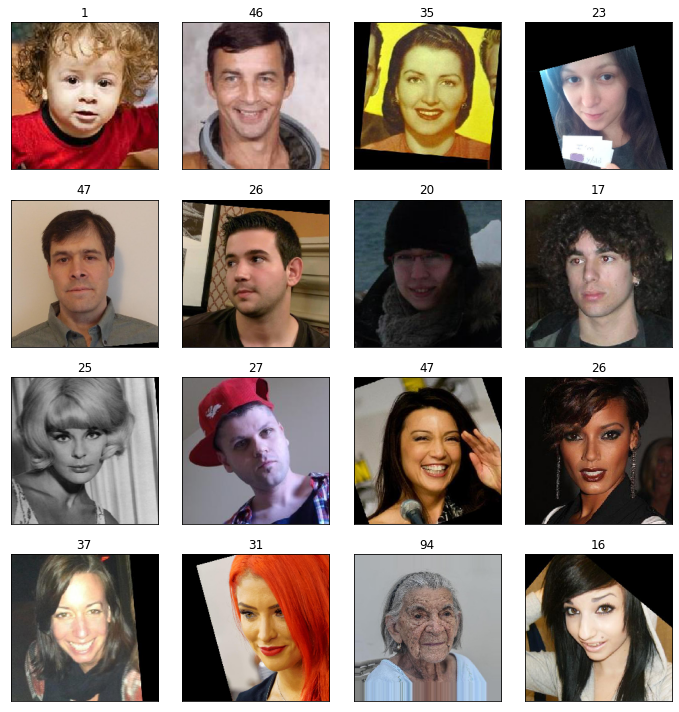

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(arr[0][i])
    plt.xticks([])
    plt.yticks([])
    plt.title(arr[1][i])
    plt.tight_layout()

Большинство изображений повернуты так, чтобы лицо располагалось вдоль вертикальной оси. Также в датасете есть старые, черно-белые фото. Лицо на разных фотографиях, особенно в случае поворота изображения, занимает достаточно различную площадь изображения.

## Обучение модели

Код в этом разделе запускается на отдельном сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    val_datagen = ImageDataGenerator(validation_split=0.25,
                                     rescale=1./255)
    val_gen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
    return val_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])

    model.summary()

    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=100,
                steps_per_epoch=None, validation_steps=None):
    if isinstance(epochs, str):
        model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size, epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2, shuffle=True)
    else:
        model.fit(train_data,
                  validation_data=test_data,
                  epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2, shuffle=True)
    return model


```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               819600    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
=================================================================
Total params: 24,512,713
Trainable params: 24,459,593
Non-trainable params: 53,120
_________________________________________________________________

Train for 178 steps, validate for 60 steps
Epoch 1/100
2022-12-16 10:59:43.231907: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-16 10:59:45.400062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 68s - loss: 268.5877 - mae: 11.7225 - val_loss: 579.6559 - val_mae: 18.9341
Epoch 2/100
178/178 - 38s - loss: 74.9773 - mae: 6.5907 - val_loss: 492.1768 - val_mae: 16.8843
Epoch 3/100
178/178 - 38s - loss: 48.2906 - mae: 5.3078 - val_loss: 254.3929 - val_mae: 11.7317
Epoch 4/100
178/178 - 38s - loss: 32.9048 - mae: 4.3730 - val_loss: 147.4001 - val_mae: 9.1089
Epoch 5/100
178/178 - 38s - loss: 23.9970 - mae: 3.7496 - val_loss: 80.5802 - val_mae: 6.6333
Epoch 6/100
178/178 - 38s - loss: 17.7997 - mae: 3.2239 - val_loss: 70.1610 - val_mae: 6.2560
Epoch 7/100
178/178 - 38s - loss: 15.3640 - mae: 2.9742 - val_loss: 70.7770 - val_mae: 6.2590
Epoch 8/100
178/178 - 37s - loss: 12.9692 - mae: 2.7213 - val_loss: 89.9648 - val_mae: 6.8935
Epoch 9/100
178/178 - 37s - loss: 11.5056 - mae: 2.5441 - val_loss: 64.1322 - val_mae: 5.8661
Epoch 10/100
178/178 - 38s - loss: 9.5940 - mae: 2.3397 - val_loss: 73.2599 - val_mae: 6.4161
Epoch 11/100
178/178 - 38s - loss: 8.7236 - mae: 2.2028 - val_loss: 64.9171 - val_mae: 5.9502
Epoch 12/100
178/178 - 38s - loss: 7.5272 - mae: 2.0579 - val_loss: 65.2859 - val_mae: 5.9463
Epoch 13/100
178/178 - 38s - loss: 7.6927 - mae: 2.0468 - val_loss: 66.3573 - val_mae: 6.1431
Epoch 14/100
178/178 - 38s - loss: 8.0240 - mae: 2.1052 - val_loss: 68.0670 - val_mae: 6.0619
Epoch 15/100
178/178 - 37s - loss: 7.1886 - mae: 1.9961 - val_loss: 64.8352 - val_mae: 5.9551
Epoch 16/100
178/178 - 38s - loss: 7.1582 - mae: 2.0086 - val_loss: 64.0906 - val_mae: 5.9439
Epoch 17/100
178/178 - 38s - loss: 7.6150 - mae: 2.0517 - val_loss: 67.5807 - val_mae: 6.2829
Epoch 18/100
178/178 - 38s - loss: 7.3833 - mae: 2.0371 - val_loss: 82.0482 - val_mae: 6.7459
Epoch 19/100
178/178 - 37s - loss: 7.0101 - mae: 1.9917 - val_loss: 62.6414 - val_mae: 5.7943
Epoch 20/100
178/178 - 38s - loss: 7.8283 - mae: 2.0924 - val_loss: 63.2257 - val_mae: 5.7798
Epoch 21/100
178/178 - 38s - loss: 7.4545 - mae: 2.0470 - val_loss: 68.7131 - val_mae: 6.2829
Epoch 22/100
178/178 - 37s - loss: 6.9037 - mae: 1.9930 - val_loss: 66.7228 - val_mae: 6.1230
Epoch 23/100
178/178 - 37s - loss: 7.4983 - mae: 2.0583 - val_loss: 62.5703 - val_mae: 5.8641
Epoch 24/100
178/178 - 38s - loss: 7.3596 - mae: 2.0513 - val_loss: 62.9570 - val_mae: 5.8440
Epoch 25/100
178/178 - 38s - loss: 6.9694 - mae: 2.0057 - val_loss: 66.8788 - val_mae: 6.0544
Epoch 26/100
178/178 - 38s - loss: 7.3771 - mae: 2.0356 - val_loss: 61.3790 - val_mae: 5.6981
Epoch 27/100
178/178 - 39s - loss: 7.5156 - mae: 2.0579 - val_loss: 62.6752 - val_mae: 5.8411
Epoch 28/100
178/178 - 38s - loss: 6.9862 - mae: 1.9452 - val_loss: 69.2022 - val_mae: 6.3978
Epoch 29/100
178/178 - 37s - loss: 6.5452 - mae: 1.8978 - val_loss: 66.0562 - val_mae: 6.0214
Epoch 30/100
178/178 - 38s - loss: 6.6792 - mae: 1.9242 - val_loss: 59.8424 - val_mae: 5.7154
Epoch 31/100
178/178 - 39s - loss: 6.4505 - mae: 1.8606 - val_loss: 61.5481 - val_mae: 5.7186
Epoch 32/100
178/178 - 38s - loss: 6.2722 - mae: 1.8515 - val_loss: 61.3962 - val_mae: 5.7282
Epoch 33/100
178/178 - 37s - loss: 5.8842 - mae: 1.7946 - val_loss: 62.8384 - val_mae: 5.9094
Epoch 34/100
178/178 - 37s - loss: 5.3189 - mae: 1.7150 - val_loss: 61.9871 - val_mae: 5.9007
Epoch 35/100
178/178 - 38s - loss: 4.8537 - mae: 1.6707 - val_loss: 61.3539 - val_mae: 5.7229
Epoch 36/100
178/178 - 37s - loss: 4.7109 - mae: 1.6225 - val_loss: 60.0204 - val_mae: 5.7666
Epoch 37/100
178/178 - 37s - loss: 4.7752 - mae: 1.6368 - val_loss: 59.4626 - val_mae: 5.6460
Epoch 38/100
178/178 - 37s - loss: 4.8131 - mae: 1.6307 - val_loss: 59.1714 - val_mae: 5.6216
Epoch 39/100
178/178 - 37s - loss: 4.8316 - mae: 1.6377 - val_loss: 64.8369 - val_mae: 5.9729
Epoch 40/100
178/178 - 38s - loss: 4.8285 - mae: 1.6233 - val_loss: 60.5001 - val_mae: 5.6945
Epoch 41/100
178/178 - 37s - loss: 4.6266 - mae: 1.5742 - val_loss: 167.4664 - val_mae: 8.0509
Epoch 42/100
178/178 - 38s - loss: 4.6077 - mae: 1.6250 - val_loss: 69.0672 - val_mae: 6.3055
Epoch 43/100
178/178 - 38s - loss: 4.4935 - mae: 1.5909 - val_loss: 60.7171 - val_mae: 5.8417
Epoch 44/100
178/178 - 37s - loss: 4.7463 - mae: 1.6224 - val_loss: 63.0496 - val_mae: 5.7967
Epoch 45/100
178/178 - 37s - loss: 4.2326 - mae: 1.5444 - val_loss: 65.4576 - val_mae: 6.0841
Epoch 46/100
178/178 - 37s - loss: 3.9993 - mae: 1.4744 - val_loss: 60.4808 - val_mae: 5.7317
Epoch 47/100
178/178 - 37s - loss: 3.9167 - mae: 1.4659 - val_loss: 63.4181 - val_mae: 5.9061
Epoch 48/100
178/178 - 37s - loss: 4.2363 - mae: 1.5047 - val_loss: 58.6384 - val_mae: 5.5626
Epoch 49/100
178/178 - 37s - loss: 4.0590 - mae: 1.4908 - val_loss: 61.0019 - val_mae: 5.7402
Epoch 50/100
178/178 - 38s - loss: 18.9598 - mae: 3.0577 - val_loss: 90.9665 - val_mae: 6.9908
Epoch 51/100
178/178 - 37s - loss: 11.1765 - mae: 2.5029 - val_loss: 67.8060 - val_mae: 6.1040
Epoch 52/100
178/178 - 37s - loss: 6.2613 - mae: 1.8726 - val_loss: 61.7395 - val_mae: 5.8140
Epoch 53/100
178/178 - 38s - loss: 3.7648 - mae: 1.4466 - val_loss: 58.6244 - val_mae: 5.5938
Epoch 54/100
178/178 - 38s - loss: 2.3911 - mae: 1.1384 - val_loss: 58.7335 - val_mae: 5.5949
Epoch 55/100
178/178 - 37s - loss: 1.6918 - mae: 0.9630 - val_loss: 57.3704 - val_mae: 5.4855
Epoch 56/100
178/178 - 37s - loss: 1.4512 - mae: 0.8915 - val_loss: 58.8315 - val_mae: 5.5482
Epoch 57/100
178/178 - 37s - loss: 1.3194 - mae: 0.8451 - val_loss: 61.3726 - val_mae: 5.7841
Epoch 58/100
178/178 - 37s - loss: 1.1981 - mae: 0.8101 - val_loss: 57.7344 - val_mae: 5.5123
Epoch 59/100
178/178 - 37s - loss: 1.0929 - mae: 0.7690 - val_loss: 56.9187 - val_mae: 5.4877
Epoch 60/100
178/178 - 37s - loss: 1.3890 - mae: 0.8535 - val_loss: 58.7679 - val_mae: 5.5910
Epoch 61/100
178/178 - 38s - loss: 1.5292 - mae: 0.8945 - val_loss: 58.7339 - val_mae: 5.6044
Epoch 62/100
178/178 - 38s - loss: 1.6705 - mae: 0.9369 - val_loss: 58.0563 - val_mae: 5.5047
Epoch 63/100
178/178 - 38s - loss: 2.0298 - mae: 1.0500 - val_loss: 59.4277 - val_mae: 5.5934
Epoch 64/100
178/178 - 38s - loss: 2.8298 - mae: 1.2247 - val_loss: 62.0491 - val_mae: 5.7825
Epoch 65/100
178/178 - 37s - loss: 3.6047 - mae: 1.3945 - val_loss: 61.7531 - val_mae: 5.7901
Epoch 66/100
178/178 - 37s - loss: 3.8414 - mae: 1.4331 - val_loss: 59.5139 - val_mae: 5.6217
Epoch 67/100
178/178 - 38s - loss: 3.6258 - mae: 1.4264 - val_loss: 60.1157 - val_mae: 5.7383
Epoch 68/100
178/178 - 39s - loss: 3.4900 - mae: 1.3922 - val_loss: 57.9401 - val_mae: 5.5798
Epoch 69/100
178/178 - 37s - loss: 3.2732 - mae: 1.3207 - val_loss: 60.7837 - val_mae: 5.6855
Epoch 70/100
178/178 - 38s - loss: 3.2220 - mae: 1.3275 - val_loss: 58.1565 - val_mae: 5.5530
Epoch 71/100
178/178 - 41s - loss: 3.0842 - mae: 1.3077 - val_loss: 58.9290 - val_mae: 5.6901
Epoch 72/100
178/178 - 41s - loss: 3.4745 - mae: 1.3458 - val_loss: 77.2362 - val_mae: 6.3991
Epoch 73/100
178/178 - 42s - loss: 6.5931 - mae: 1.8879 - val_loss: 60.5890 - val_mae: 5.6315
Epoch 74/100
178/178 - 42s - loss: 4.5314 - mae: 1.5810 - val_loss: 61.1569 - val_mae: 5.6726
Epoch 75/100
178/178 - 43s - loss: 3.6906 - mae: 1.4426 - val_loss: 69.0102 - val_mae: 5.9479
Epoch 76/100
178/178 - 41s - loss: 2.9053 - mae: 1.2696 - val_loss: 63.6605 - val_mae: 5.8289
Epoch 77/100
178/178 - 39s - loss: 2.2932 - mae: 1.1230 - val_loss: 59.4725 - val_mae: 5.6121
Epoch 78/100
178/178 - 38s - loss: 1.7456 - mae: 0.9809 - val_loss: 56.4682 - val_mae: 5.4824
Epoch 79/100
178/178 - 41s - loss: 1.5397 - mae: 0.9104 - val_loss: 57.5794 - val_mae: 5.5023
Epoch 80/100
178/178 - 42s - loss: 1.2973 - mae: 0.8329 - val_loss: 60.5775 - val_mae: 5.6775
Epoch 81/100
178/178 - 39s - loss: 1.2622 - mae: 0.8309 - val_loss: 59.5299 - val_mae: 5.6120
Epoch 82/100
178/178 - 39s - loss: 1.3325 - mae: 0.8420 - val_loss: 57.0879 - val_mae: 5.5267
Epoch 83/100
178/178 - 38s - loss: 1.4827 - mae: 0.8769 - val_loss: 58.8567 - val_mae: 5.5742
Epoch 84/100
178/178 - 39s - loss: 1.7624 - mae: 0.9724 - val_loss: 59.1033 - val_mae: 5.4900
Epoch 85/100
178/178 - 39s - loss: 2.2165 - mae: 1.0879 - val_loss: 58.3396 - val_mae: 5.6696
Epoch 86/100
178/178 - 42s - loss: 2.9346 - mae: 1.2460 - val_loss: 63.8319 - val_mae: 5.9208
Epoch 87/100
178/178 - 43s - loss: 2.9224 - mae: 1.2709 - val_loss: 58.3764 - val_mae: 5.5196
Epoch 88/100
178/178 - 41s - loss: 2.9537 - mae: 1.2697 - val_loss: 58.3631 - val_mae: 5.5081
Epoch 89/100
178/178 - 39s - loss: 2.9649 - mae: 1.2743 - val_loss: 61.4587 - val_mae: 5.8058
Epoch 90/100
178/178 - 39s - loss: 2.6063 - mae: 1.1838 - val_loss: 58.2389 - val_mae: 5.5383
Epoch 91/100
178/178 - 43s - loss: 2.2670 - mae: 1.1206 - val_loss: 59.0377 - val_mae: 5.5686
Epoch 92/100
178/178 - 43s - loss: 2.3139 - mae: 1.1156 - val_loss: 61.7743 - val_mae: 5.6946
Epoch 93/100
178/178 - 44s - loss: 2.0800 - mae: 1.0696 - val_loss: 74.0868 - val_mae: 6.4717
Epoch 94/100
178/178 - 40s - loss: 1.9282 - mae: 1.0286 - val_loss: 59.9293 - val_mae: 5.6412
Epoch 95/100
178/178 - 40s - loss: 1.8694 - mae: 0.9991 - val_loss: 65.9239 - val_mae: 6.0339
Epoch 96/100
178/178 - 39s - loss: 1.8028 - mae: 0.9900 - val_loss: 57.2842 - val_mae: 5.4793
Epoch 97/100
178/178 - 39s - loss: 1.7893 - mae: 0.9751 - val_loss: 59.4499 - val_mae: 5.5435
Epoch 98/100
178/178 - 40s - loss: 1.9473 - mae: 1.0050 - val_loss: 56.0723 - val_mae: 5.4540
Epoch 99/100
178/178 - 43s - loss: 1.8308 - mae: 0.9923 - val_loss: 63.0729 - val_mae: 5.7820
Epoch 100/100
178/178 - 43s - loss: 1.8148 - mae: 0.9755 - val_loss: 61.7034 - val_mae: 5.6470

60/60 - 10s - loss: 61.7034 - mae: 5.6470
Test MAE: 5.6470

```

## Анализ обученной модели

Датасет был разделен на обучающую и валидационную выборки в соотношении 3 к 1 (25% валидация). Проведена аугментация данных горизонтальным отражением. Наилучший результат показала модель с 4-мя полносвязными слоями с уменьшающимся количеством нейронов в два раза начиная с 400 нейронов с функцией активации 'relu' для каждого слоя, включая выходной. Начальный шаг оптимизирующей функции 'Adam' взят 0.0001, использована функция потерь MSE. Итоговая тестовая MAE - 5.6470.

В итоге модель может неплохо аппроксимировать возраст человека на интревале десятилетия, возможно это можно использовать как признак при анализе спроса и последующего построения рекомендательных систем. Однако для контроля продаж спиртного и табачной продукции вряд ли возможно использовать модель с ожидаемым отклонением в диапазоне 10-11 лет.